## Improving Computer Vision Accuracy using Convolutions

In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images = training_images / 255.0
test_images = test_images / 255.0
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = tf.nn.relu),
    tf.keras.layers.Dense(10, activation = tf.nn.softmax)
])
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.fit(training_images, training_labels, epochs = 5)

test_loss = model.evaluate(test_images, test_labels)

Epoch 1/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5002 - accuracy: 0.8244
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3767 - accuracy: 0.8654
Epoch 3/5
1875/1875 [==============================] - 2s 972us/step - loss: 0.3373 - accuracy: 0.8767
Epoch 4/5
1875/1875 [==============================] - 2s 967us/step - loss: 0.3112 - accuracy: 0.8864
Epoch 5/5
313/313 [==============================] - 0s 722us/step - loss: 0.3586 - accuracy: 0.8733


Your accuracy is probably about 89% on training and 87% on validation...not bad...But how do you make that even better? One way is to use something called Convolutions.

In [7]:
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images=training_images.reshape(60000, 28, 28, 1)
training_images=training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images=test_images/255.0

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'softmax')
])
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()
model.fit(training_images, training_labels, epochs = 5)

test_loss = model.evaluate(test_images, test_labels)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               204928    
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

It's likely gone up to about 93% on the training data and 91% on the validation data.

That's significant, and a step in the right direction!

Try running it for more epochs -- say about 20, and explore the results! But while the results might seem really good, the validation results may actually go down, due to something called 'overfitting' which will be discussed later.

You'll notice that there's a bit of a change here in that the training data needed to be reshaped. That's because the first convolution expects a single tensor containing everything, so instead of 60,000 28x28x1 items in a list, we have a single 4D list that is 60,000x28x28x1, and the same for the test images. If you don't do this, you'll get an error when training as the Convolutions do not recognize the shape.

\# Parameters of calculation:

Conv2D Layers:
    
    param_number = output_channel_number * (input_channel_number * kernel_height * kernel_width + 1)
    e.g. 64 * (1 * 3 * 3 + 1) = 640; 64 * (64 *3 * 3 + 1) = 36928
    
Flatten:

    simply flattens the input data
    
Dense Layers:

    param_number = output_channel_number * (input_channel_number + 1)
    e.g. 128 * (1600 + 1)  204928; 10 * (128 + 1) = 1290

## Visualizing the Convolutions and Pooling

The print (test_labels[:100]) shows us the first 100 labels in the test set, and you can see that the ones at index 0, index 23 and index 28 are all the same value (9). They're all shoes. Let's take a look at the result of running the convolution on each, and you'll begin to see common features between them emerge.

In [9]:
print(test_labels[:100])

[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 3 7 6 7 2 1 2 2 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 2 3 9 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4 2]


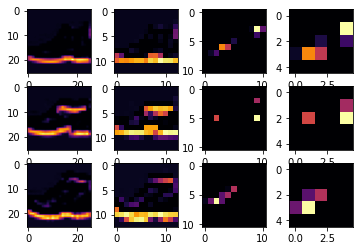

In [18]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(3,4)
FIRST_IMAGE=0
SECOND_IMAGE=23
THIRD_IMAGE=28
CONVOLUTION_NUMBER = 1
from tensorflow.keras import models
layer_outputs = [layer.output for layer in model.layers]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)

for x in range(0,4):
    f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
    axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
    axarr[0,x].grid(False)
    f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
    axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
    axarr[1,x].grid(False)
    f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
    axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
    axarr[2,x].grid(False)